<a href="https://colab.research.google.com/github/sabrinaaquino/qdrant-and-camel-discord-bot/blob/main/Agentic_RAG_Discord_Bot_with_CAMEL_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

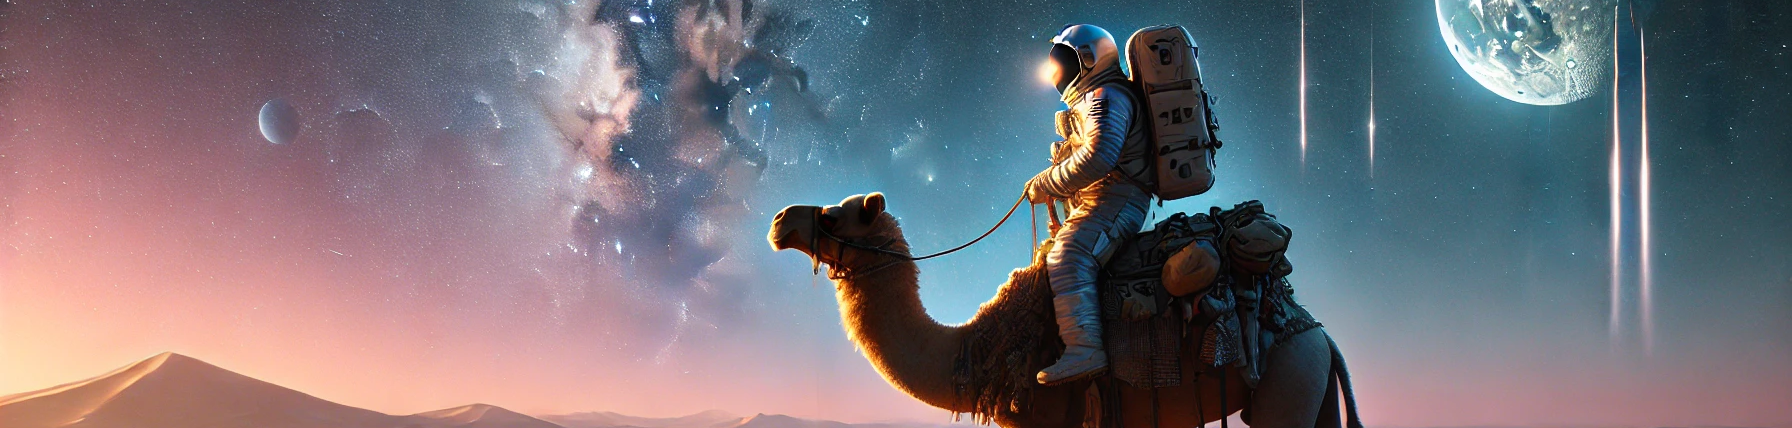

# Building an Agentic RAG Discord ChatBot with Qdrant, CAMEL-AI, and OpenAI
Unlike traditional RAG techniques, which passively retrieve context and generate responses, **agentic RAG** involves active decision-making and multi-step reasoning by the chatbot. This approach allows the bot to dynamically interact with various data sources, adapt its behavior based on context, and perform more complex tasks autonomously.

In this tutorial, we’ll develop a Discord chatbot using agentic RAG principles. The bot will use:

- Qdrant for efficient vector search,
- [CAMEL-AI](https://www.camel-ai.org/) for dialogue management, and
- OpenAI models for generating embeddings and responses.

You'll learn how to set up the environment, scrape and prepare data, and deploy a fully functional chatbot on Discord.


| Step                  | Description                                                                                              |
|-----------------------|----------------------------------------------------------------------------------------------------------|
| 1. Environment Setup  | Install necessary libraries and dependencies.                                                           |
| 2. Qdrant Configuration | Create a Qdrant Cloud account, set up a cluster, and connect using the API key and cluster URL.         |
| 3. Data Scraping      | Scrape relevant documentation from Qdrant's website for knowledge base creation.                        |
| 4. Chunking & Embedding | Chunk large texts and generate embeddings using OpenAI.                                                 |
| 5. Vector Store Creation | Create and populate a Qdrant collection with the generated embeddings.                                  |
| 6. Context Retrieval  | Define a function to retrieve context from Qdrant based on user queries.                                |
| 7. Discord Bot Setup  | Configure a new Discord bot, invite it to a server, and grant necessary permissions.                    |
| 8. Bot Integration    | Integrate the bot with Qdrant and CAMEL-AI to handle user interactions and provide responses.           |
| 9. Testing            | Test the bot in a live Discord server.                                                                 |

## Workflow Overview
The workflow starts with data ingestion. HTML documents are scraped using BeautifulSoup to extract text content, forming the knowledge base for the system.

The embeddings and metadata are stored in a Qdrant collection for structured storage and retrieval. When a user sends a query through the Discord bot, CAMEL-AI's Qdrant Storage Class interfaces with Qdrant to retrieve relevant vectors based on the query.

The retrieved vectors are processed by an AI agent using OpenAI's language model. The AI agent generates a response that is contextually relevant to the user's query. This response is then delivered back to the user through the Discord bot interface, completing the flow.

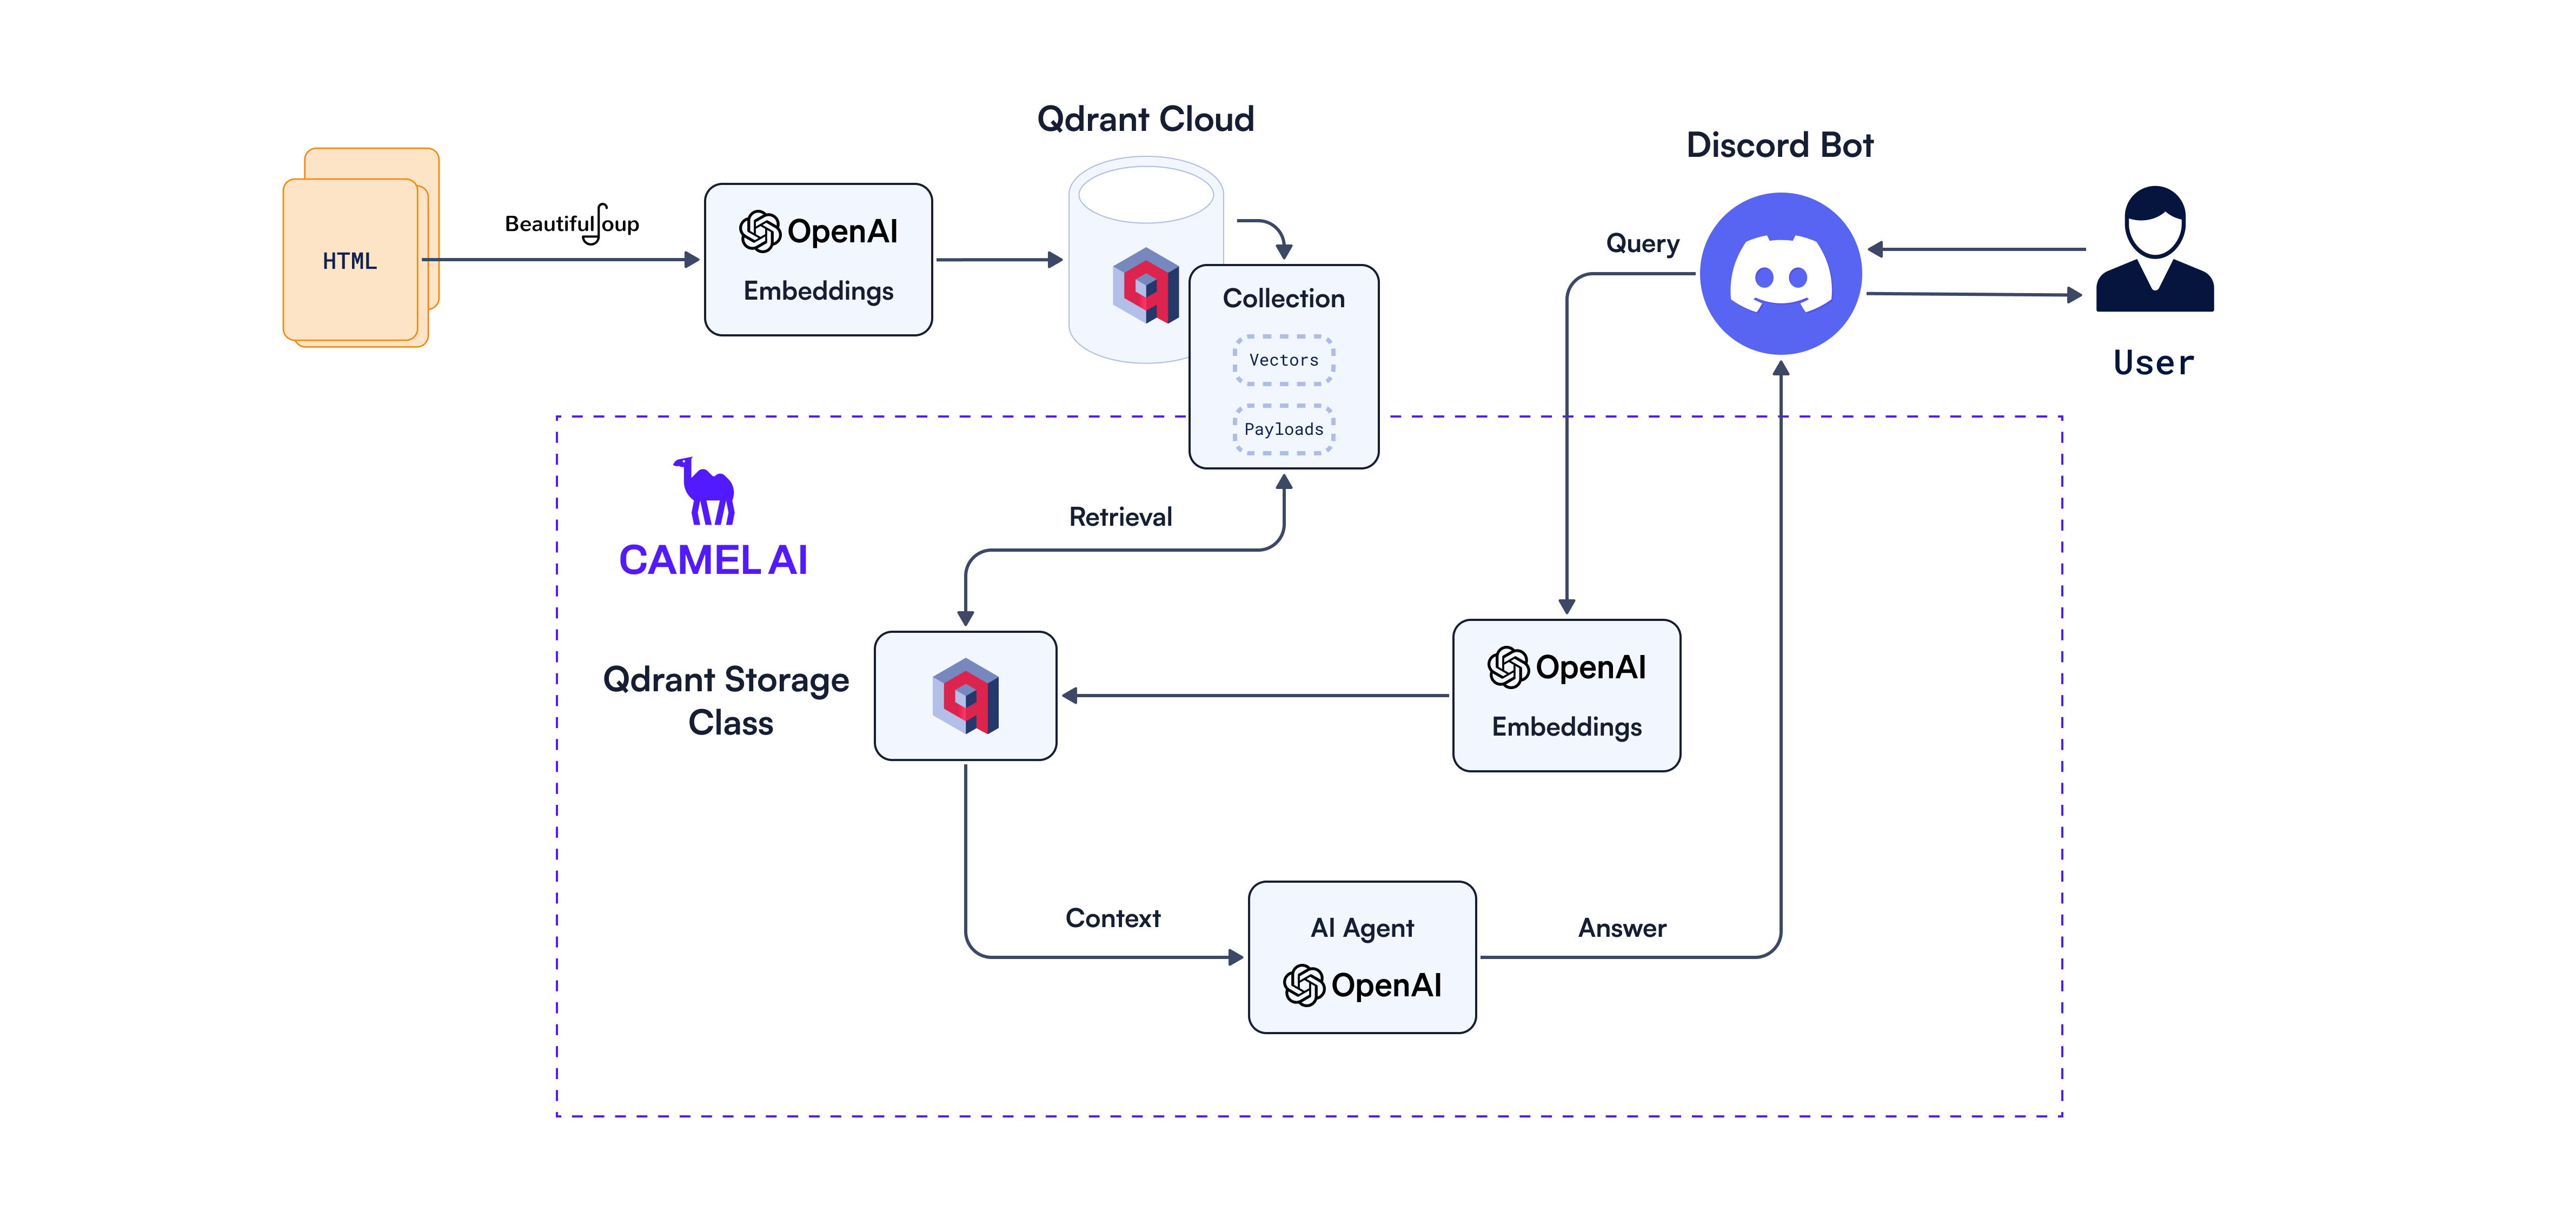

## **Step 1: Environment Setup**
To build our chatbot, we'll need a set of core libraries for embedding generation, vector storage, web scraping, and interacting with the Discord API.

In [ ]:
!pip install openai qdrant-client camel-ai[all]==0.2.16 requests beautifulsoup4 nest_asyncio discord.py tqdm python-dotenv

  Using cached camel_ai-0.2.16-py3-none-any.whl.metadata (34 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 77.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 58.0 MB/s eta 0:00:00



## Set up API key for OpenAI
**Create an OpenAI Account**: Go to [OpenAI](https://platform.openai.com/signup) and sign up for an account if you don’t already have one.

2. **Generate an API Key**:

    - After logging in, click on your profile icon in the top-right corner and select **API keys**.

    - Click **Create new secret key**.

    - Copy the generated API key and store it securely. You won’t be able to see it again.

In [ ]:
import os
from getpass import getpass

openai_api_key = getpass('Enter your API key: ')
os.environ["OPENAI_API_KEY"] = openai_api_key

Enter your API key: ··········


In [ ]:
import openai
import os
from dotenv import load_dotenv

load_dotenv()

openai_client = openai.Client(
    api_key=os.getenv("OPENAI_API_KEY")
)


##** Step 2. Configure the Qdrant client**
For this tutorial, we will be using the **Qdrant Cloud Free Tier**. Here's how to set it up:

1. **Create an Account**:  Sign up for a Qdrant Cloud account at [Qdrant Cloud](https://cloud.qdrant.io).

2. **Create a Cluster**:  
   - Navigate to the **Overview** section.  
   - Follow the onboarding instructions under **Create First Cluster** to set up your cluster.  
   - When you create the cluster, you will receive an **API Key**. Copy and securely store it, as you will need it later.  


In [ ]:
import os
from getpass import getpass
from qdrant_client import QdrantClient

# Prompt user to enter Qdrant Cloud API key
qdrant_api_key = getpass('Enter your Qdrant Cloud API key: ')
os.environ["QDRANT_CLOUD_API_KEY"] = qdrant_api_key

# Set Qdrant Cloud URL
qdrant_cloud_url = input('Enter your Qdrant Cloud URL: ')
os.environ["QDRANT_CLOUD_URL"] = qdrant_cloud_url

# Define collection name
collection_name = "discord-bot"

# Initialize Qdrant client
client = QdrantClient(
    url=os.getenv("QDRANT_CLOUD_URL"),
    api_key=os.getenv("QDRANT_CLOUD_API_KEY")
)

Enter your Qdrant Cloud API key: ··········
Enter your Qdrant Cloud URL: https://a80d6200-a5b9-4a54-9253-10a436e56601.europe-west3-0.gcp.cloud.qdrant.io


## **Step 3: Scrape and Prepare Data**
Use BeautifulSoup to scrape content from Qdrant's documentation or other URLs of your choice. The extracted text will be prepared for embedding and later used for querying.

In [ ]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

qdrant_urls = [
    "https://qdrant.tech/documentation/overview",
    "https://qdrant.tech/documentation/guides/installation",
    "https://qdrant.tech/documentation/concepts/filtering",
    "https://qdrant.tech/documentation/concepts/indexing",
    "https://qdrant.tech/documentation/guides/distributed_deployment",
    "https://qdrant.tech/documentation/guides/quantization"
    # Add more URLs as needed
]

def scrape_qdrant_pages(urls):
    documents = []
    metadata = []
    for url in tqdm(urls, desc="Scraping URLs"):
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            text = soup.get_text(separator="\n", strip=True)
            if text:
                documents.append(text)
                metadata.append({"source_url": url})
        except Exception as e:
            print(f"Error scraping {url}: {e}")
    return documents, metadata

all_docs, all_metadata = scrape_qdrant_pages(qdrant_urls)

Scraping URLs: 100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


## **Step 4: Chunk Large Texts**
Since some of the scraped documents might be large, we need to split them into smaller, manageable chunks before generating embeddings.

In [ ]:
def chunk_texts_with_metadata(texts, metadata, max_length=500):
    chunks = []
    chunk_metadata = []
    for doc_index, text in enumerate(texts):
        words = text.split()
        for i in range(0, len(words), max_length):
            chunk = " ".join(words[i:i + max_length])
            chunks.append(chunk)
            chunk_metadata.append(metadata[doc_index])  # Associate metadata with each chunk
    return chunks, chunk_metadata

# Create chunked docs and corresponding metadata
chunked_docs, chunked_metadata = chunk_texts_with_metadata(all_docs, all_metadata)

### Generate Embeddings Using OpenAI

In [ ]:
embedding_model = "text-embedding-3-small"

result = openai_client.embeddings.create(input=chunked_docs, model=embedding_model)

## **Step 5: Create a Collection and Upload the Points**
Before creating and populating the Qdrant collection, we need to structure the data into points:
### Create Points for Qdrant

In [ ]:
from qdrant_client.models import PointStruct

# Create points for Qdrant
points = [
    PointStruct(
        id=idx,  # Unique ID for each point
        vector=data.embedding,  # Access embedding as an attribute
        payload={
            "text": text,  # Use chunked text
            "source_url": chunked_metadata[idx]['source_url']  # Attach corresponding metadata
        },
    )
    for idx, (data, text) in enumerate(zip(result.data, chunked_docs))
]

### Create the Collection
We use a vector size of 1536 because it's the dimensionality of embeddings produced by OpenAI's model `text-embedding-3-small`.

In [ ]:
from qdrant_client.models import VectorParams, Distance

if not client.collection_exists(collection_name):

    client.create_collection(
        collection_name,
        vectors_config=VectorParams(
        size=1536,
        distance=Distance.COSINE,
        ),
    )

### Upload the points to Qdrant

In [ ]:
client.upsert(collection_name=collection_name, points=points)

UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

## **Step 5: Setup the CAMEL-AI Instances**
### Set the Qdrant Storage Instance
The `QdrantStorage` class provides methods for reading from and writing to a Qdrant instance. You can now pass an instance of this class to retrievers to interact with your Qdrant collections.


In [ ]:
from camel.storages import QdrantStorage, VectorDBQuery, VectorRecord
from camel.types import VectorDistance

qdrant_storage = QdrantStorage(
    url_and_api_key=(
        qdrant_cloud_url,
        qdrant_api_key,
    ),
    collection_name="qdrant_documentation",
    distance=VectorDistance.COSINE,
    vector_dim=1536,
)

### Set the OpenAI Instance

Define the OpenAI model and create a CAMEL-AI compatible OpenAI instance.

In [ ]:
from camel.configs import ChatGPTConfig
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType

# Create a ChatGPT configuration
config = ChatGPTConfig(temperature=0.2).as_dict()

# Create an OpenAI model using the configuration
openai_model = ModelFactory.create(
    model_platform=ModelPlatformType.OPENAI,
    model_type=ModelType.GPT_4O_MINI,
    model_config_dict=config,
)

# Use the created model
model = openai_model

## **Step 6: Define the AutoRetriever**

Next, define the let's define the AutoRetriever implementation that handles both embedding and storing data and executing queries.



In [ ]:
from camel.types import StorageType
from camel.agents import ChatAgent
from camel.retrievers import AutoRetriever


assistant_sys_msg = """You are a helpful assistant to answer question,
         I will give you the Original Query and Retrieved Context,
        answer the Original Query based on the Retrieved Context,
        if you can't answer the question just say I don't know."""

auto_retriever = AutoRetriever(
              url_and_api_key=(
                qdrant_cloud_url,
                qdrant_api_key,
              ),
              storage_type=StorageType.QDRANT,
              embedding_model=OpenAIEmbedding()
            )

qdrant_agent = ChatAgent(system_message=assistant_sys_msg, model=openai_model)

{'Original Query': 'What is filtering', 'Retrieved Context': [{'similarity score': '0.41812798', 'content path': 'https://qdrant.tech/articles/what-is-a-vector-database/', 'metadata': {'filetype': 'text/html', 'languages': ['eng'], 'link_texts': ['Complete Guide to Filtering.'], 'link_urls': ['https://qdrant.tech/articles/vector-search-filtering/'], 'url': 'https://qdrant.tech/articles/what-is-a-vector-database/'}, 'extra_info': {}, 'text': 'For example, if you’re searching for a picture of a dog, the vector helps the database find images that are visually similar. But let’s say you want results showing only images taken within the last year, or those tagged with “vacation.”\n\nThe payload can help you narrow down those results by ignoring vectors that doesn’t match your query vector filtering criteria. If you want the full picture of how filtering works in Qdrant, check out our Complete Guide to Filtering.'}, {'similarity score': '0.34563252', 'content path': 'https://qdrant.tech/arti

## **Step 7: Create and Configure the Discord Bot**

Now let's bring the bot to life! It will serve as the interface through which users can interact with the agentic RAG system you’ve built.

### Create a New Discord Bot

1. Go to the [Discord Developer Portal](https://discord.com/developers/applications) and log in with your Discord account.

2. Click on the **New Application** button.

3. Give your application a name and click **Create**.

4. Navigate to the **Bot** tab on the left sidebar and click **Add Bot**.

5. Once the bot is created, click **Reset Token** under the **Token** section to generate a new bot token. Copy this token securely as you will need it later.

### Invite the Bot to Your Server

1. Go to the **OAuth2** tab and then to the **URL Generator** section.

2. Under **Scopes**, select **bot**.

3. Under **Bot Permissions**, select the necessary permissions:

   - Send Messages

   - Read Message History

4. Copy the generated URL and paste it into your browser.

5. Select the server where you want to invite the bot and click **Authorize**.

### Grant the Bot Permissions

1. Go back to the **Bot** tab.

2. Enable the following under **Privileged Gateway Intents**:

   - Server Members Intent

   -  Message Content Intent

Now, the bot is ready to be integrated with your code.

## **Step 8: Build the Discord Bot**

In [ ]:
import os
from getpass import getpass

discord_bot_token = getpass('Enter your Token: ')
os.environ["DISCORD_BOT_TOKEN"] = discord_bot_token

Enter your Token: ··········


We'll use `discord.py` to create a simple Discord bot that interacts with users and retrieves context from Qdrant before responding.

This code cell sets up a simple Discord bot using the `DiscordApp` class from the `camel.bots` library. The bot listens for messages in any channel it has access to and provides a response based on the input message.

In [ ]:
from camel.bots import DiscordApp
import nest_asyncio
import discord

nest_asyncio.apply()
discord_q_bot = DiscordApp(token=os.getenv("DISCORD_BOT_TOKEN"))

@discord_q_bot.client.event # triggers when a message is sent in the channel
async def on_message(message: discord.Message):
    if message.author == discord_q_bot.client.user:
        return

    if message.type != discord.MessageType.default:
        return

    if message.author.bot:
        return
    user_input = message.content

    retrieved_info = auto_retriever.run_vector_retriever(
        query=user_input,
        contents=[
            "https://qdrant.tech/articles/what-is-a-vector-database/",
        ],
        top_k=10,
        similarity_threshold = 0.3,
        return_detailed_info=True,
    )

    user_msg = str(retrieved_info)
    assistant_response = qdrant_agent.step(user_msg)
    response_content = assistant_response.msgs[0].content

    if len(response_content) > 2000: # discord message length limit
        for chunk in [response_content[i:i+2000] for i in range(0, len(response_content), 2000)]:
            await message.channel.send(chunk)
    else:
        await message.channel.send(response_content)

discord_q_bot.run()

2025-01-17 22:25:13 INFO     discord.client logging in using static token
2025-01-17 22:25:13 INFO     discord.client logging in using static token
2025-01-17 22:25:13 INFO     discord.client logging in using static token
2025-01-17 22:25:13 INFO     discord.client logging in using static token
2025-01-17 22:25:13 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token
2025-01-17 22:25:14 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 09cb9f3243007785488158b694a45458).
2025-01-17 22:25:14 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 09cb9f3243007785488158b694a45458).
2025-01-17 22:25:14 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 09cb9f3243007785488158b694a45458).
2025-01-17 22:25:14 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: 09cb9f3243007785488158b694a45458).
2025-01-17 22:25:14 INFO     discord.gateway Shard I

## **Step 9: Test the Bot**

1. Invite your bot to your Discord server using the OAuth2 URL from the Discord Developer Portal.

2. Run the notebook.

3. Start chatting with the bot in your Discord server. It will retrieve context from Qdrant and provide relevant answers based on your queries.

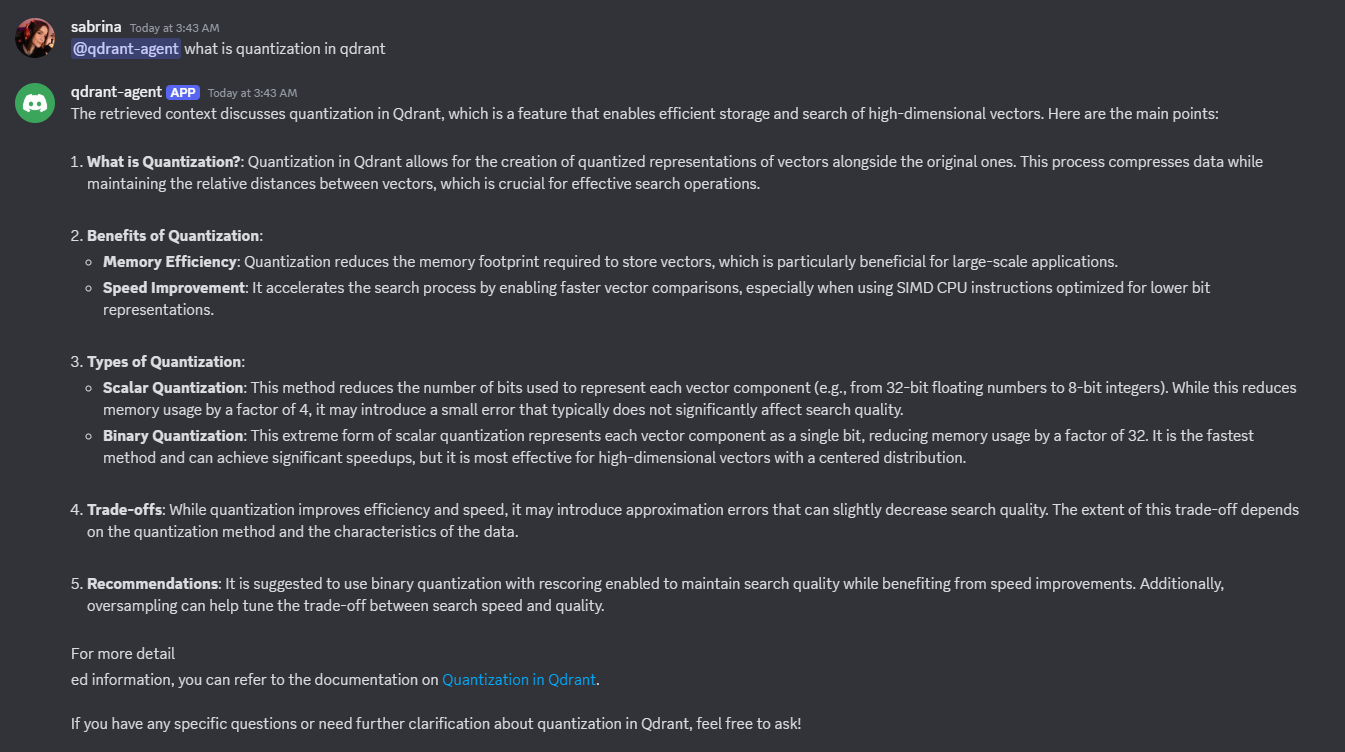